In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Load data

In [3]:
from keras.datasets import fashion_mnist

(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


In [4]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [6]:
CLASS_LABELS = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
]

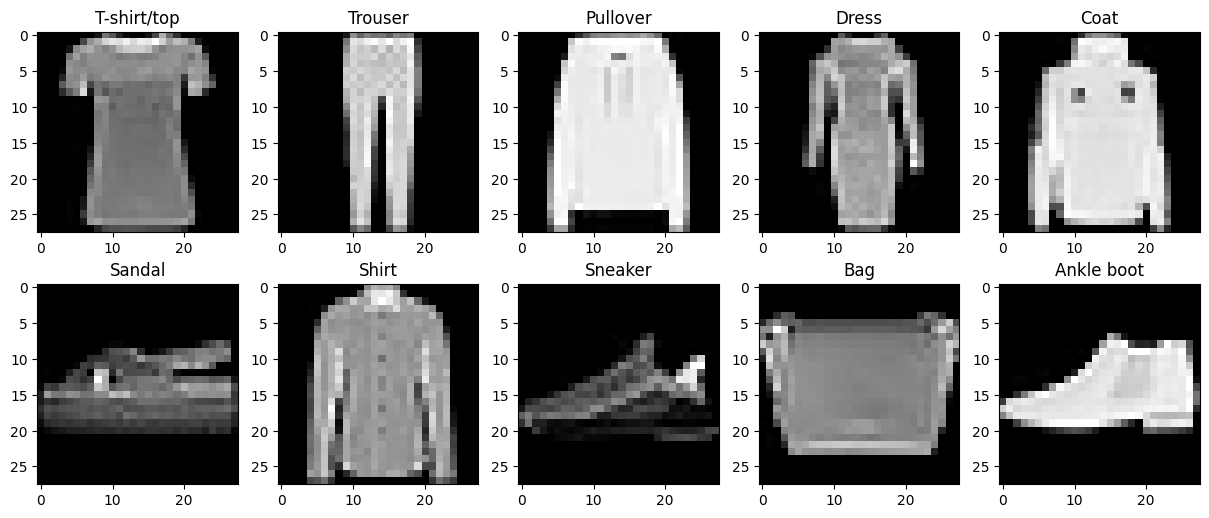

In [11]:
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    row_no = i//5
    col_no = i%5
    X_sub = X_train[Y_train==i]
    index = np.random.choice(a=range(len(X_sub)), size=1)
    ax[row_no][col_no].imshow(X_sub[index].reshape((28, 28)), cmap='gray')
    ax[row_no][col_no].set_title(CLASS_LABELS[i])

## Feedforward neural network

In [25]:
class Layer():
    """
    Models a single layer of a feedforward neural network. 

    Args:
        input_size (int): number of inputs to the layer
        output_size (int): number of outputs produced by the layer
        activation (str, optional): activation function used by the layer. 
            Allowed activations: 'identity', 'sigmoid', 'tanh', 'relu', 'softmax'
            Defaults to 'identity'.
        weight_init (str, optional): type of initialization to be performed for the weights and biases
            Allowed initializations: 'random', 'xavier'
            Defaults to 'random'.
    """
    def __init__(
        self,
        input_size: int,
        output_size: int,
        activation: str = 'identity',
        weight_init: str = 'random'
    ) -> None:
        # Handle to allow weight init
        self.w = np.random.normal(size=(output_size, input_size))   # shape: (output_size, input_size)
        self.b = np.random.normal(size=(output_size,))  # shape: (output_size,)
        self.activation = activation # Handle after implementing the activation functions
    
    def forward(self, x: np.array) -> np.array:
        """
        Computes the output of the layer for given input.

        Arg: x (numpy.array): the input vector for the layer, of size (input_size,)
        Returns: h (numpy.array): the output produced by the layer, of size (output_size,)
        """
        return np.matmul(self.w, x) + self.b # Include activation here

In [26]:
class FeedForwardNeuralNetwork():
    """
    Models a vanilla feedforward neural network, with softmax activation for the outputs.

    Args:
        input_size (int): size/dimension of inputs given to the network
        output_size (int): number of outputs produced by the network
        num_layers (int): number of hidden layers in the network
        hidden_size (int): number of neurons per hidden layer
        activation (str, optional): activation function for the hidden layers.
            Allowed activations: 'identity', 'sigmoid', 'tanh', 'relu', 'softmax'
            Defaults to 'identity'.
        weight_init (str, optional): type of initialization to be performed for the weights and biases
            Allowed initializations: 'random', 'xavier'
            Defaults to 'random'.
    """
    def __init__(
        self,
        input_size: int,
        output_size: int,
        num_layers: int,
        hidden_size: int,
        activation: str = 'identity',
        weight_init: str = 'random'
    ) -> None:
        self.input_layer = Layer(input_size, hidden_size, activation, weight_init)
        self.hidden_layers = []
        for i in range(num_layers):
            self.hidden_layers.append(Layer(hidden_size, hidden_size, activation, weight_init))
        self.output_layer = Layer(hidden_size, output_size, 'softmax', weight_init)
    
    def forward(self, x: np.array) -> np.array: # consider a name change, or add a predict function
        """
        Computes the output of the network for given input.

        Arg: x (numpy.array): the input to the network, of size (input_size,)
        Returns: y_hat (numpy.array): the output produced by the network, of size (output_size,)
        """
        result = self.input_layer.forward(x)
        for hidden_layer in self.hidden_layers:
            result = hidden_layer.forward(result)
        return self.output_layer.forward(result)
